# Module 1 — Hands-On 1.7 (C): Go-Further
Pick one base (A: Titanic classification, or B: Housing regression) and complete **2–3 mini-extensions** below.
Keep code simple; focus on reasoning & comparison. **Seed = 1955**.

## Setup — Choose a Track

### Setup & Dataset Selection

Set the `track` variable to `'titanic'` or `'housing'`.
- **Titanic** → binary classification (`Survived`).
- **Housing** → regression (`price`).

Run the cell to load the dataset and preview the first few rows.

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Choose your track: 'titanic' or 'housing'
track = 'housing'  # <-- change to 'titanic' to run the Titanic option

SEED = 1955

# Load the chosen dataset
if track == 'titanic':
    df = pd.read_csv('../data/titanic_synth.csv')  # adjust path as needed
    target_col = 'Survived'
    print("Loaded Titanic (Classification) dataset.")
else:
    df = pd.read_csv('../data/housing_synth.csv')  # adjust path as needed
    target_col = 'price'
    print("Loaded Housing (Regression) dataset.")

# Quick peek at the data
df.head()


Loaded Housing (Regression) dataset.


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,1338,2,1,5,0.351,29.93,180619.0
1,853,3,2,72,0.252,23.88,380214.0
2,2081,3,1,28,0.405,26.82,328780.0
3,475,4,2,25,0.421,14.11,358725.0
4,2113,4,2,45,0.194,26.32,266528.0


**Explanation:** Set `choice` to select your dataset; the tasks below reference earlier pipeline steps.

## Mini-Extensions (Pick Any 2–3)
### Titanic (Classification)
1) **Model swap:** Replace Decision Tree with `LogisticRegression`. Compare **Accuracy**.
2) **Threshold tuning:** Use `predict_proba` and thresholds {0.3, 0.5, 0.7}. Compare **precision/recall**.
3) **One new feature:** e.g., `Fare_per_age = Fare / (Age+1e-9)`. Retrain and note Accuracy change.
4) **Simple CV:** 5-fold cross-validation Accuracy (mean ± std) on the pipeline.

### Housing (Regression)
1) **Model swap:** Compare `LinearRegression` vs `Ridge(alpha=1.0)`. Print **RMSE/R²**.
2) **One new feature:** e.g., `sqft_per_bed = sqft / (bedrooms+1e-9)`. Retrain and note RMSE change.
3) **Robust imputation:** Compare `median` vs `mean` imputation for `sqft` after injecting NaNs.
4) **Simple CV:** 5-fold cross-validation RMSE (mean ± std) on the model.

## Titanic Option (Classification)

All cells in this section execute only if track == 'titanic'. We've included sample snippets below to help you solve the mini-extensions. Try to complete them before you see the potential solutions.

### Sample Snippets - Titanic - Take a peek once you attempted the mini extensions

#### Mini-Extension 1 – Model Swap (Decision Tree vs Logistic Regression)

In [ ]:
if track != 'titanic': #Note: this is just a check to make sure you are working on the Titanic track
    print("Skipping (current track is not 'titanic').")
else:
    # Imports specific to this block
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression

    # Features/labels split
    X = df.drop('Survived', axis=1)
    y = df['Survived']

    # Identify categorical columns for one-hot encoding
    cat = X.select_dtypes(include=['object']).columns.tolist()

    # Preprocess: one-hot encode categoricals, pass numeric as-is
    pre = ColumnTransformer(
        [('cat', OneHotEncoder(handle_unknown='ignore'), cat)],
        remainder='passthrough'
    )

    # Train/test split (stratified for class balance)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    # Two candidate models
    models = {
        'DecisionTree': DecisionTreeClassifier(max_depth=4, random_state=SEED),
        'LogisticRegression': LogisticRegression(max_iter=300, random_state=SEED)
    }

    # Fit & evaluate each model with the same preprocessing
    for name, mdl in models.items():
        pipe = Pipeline([('pre', pre), ('model', mdl)])
        pipe.fit(Xtr, ytr)
        yhat = pipe.predict(Xte)
        acc = accuracy_score(yte, yhat)
        print(f"{name:18s} → Accuracy: {acc:.3f}")


**How the code works (Titanic Model Swap)**
- Build a **ColumnTransformer** that one-hot encodes all object columns.
- Use the same preprocessing in a **Pipeline** with either a **tree** or **logistic** model.
- Train/test split is **stratified** to preserve the label distribution.
- Report test **Accuracy** for a fair, side-by-side comparison.

**Why it matters:** Try a **nonlinear tree** vs a **linear probabilistic model** (logistic regression).  
Trees find *if/else* splits; LogisticRegression learns a *smooth decision boundary*. Compare how they generalize.


##### Interpreting the Model-Swap Results

| Model | Accuracy | Interpretation |
|--------|-----------|----------------|
| **Decision Tree** | 0.500 | The tree guessed each class correctly about half of the time—no better than random chance for a balanced dataset. |
| **Logistic Regression** | 0.521 | Slightly better than the tree, but still only a very small improvement over random guessing. |

##### What this means
- These **low accuracies** show that our current features (Age, Sex, Fare, Embarked, etc.) don’t provide strong predictive power in the synthetic dataset.  
- Because this Titanic data was **randomly generated**, there is no real relationship between the input features and survival outcome.  
- The models therefore learn only noise, leading to near-50 % performance.

##### Key takeaways
- The results are realistic for **pattern-less data**—the models can’t create information that isn’t there.  
- In the real Titanic dataset, you would expect much higher accuracy (≈ 0.75 – 0.85) once real correlations exist (e.g., females and children survive more).  
- This is a good demonstration that **model quality depends entirely on data quality and structure**.


#### Mini-Extension 2 – Threshold Tuning (only Titanic)

In [ ]:
if track != 'titanic': #Note: this is just a check to make sure you are working on the Titanic track
    print("Skipping (current track is not 'titanic').")
else:
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_score, recall_score

    X = df.drop('Survived', axis=1)
    y = df['Survived']

    cat = X.select_dtypes(include=['object']).columns.tolist()
    pre = ColumnTransformer(
        [('cat', OneHotEncoder(handle_unknown='ignore'), cat)],
        remainder='passthrough'
    )

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    # Logistic model outputs probabilities
    clf = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=300, random_state=SEED))])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:, 1]  # probability of class 1

    # Convert probabilities to 0/1 predictions using different thresholds
    for thr in [0.30, 0.50, 0.70]:
        y_pred = (proba >= thr).astype(int)
        p = precision_score(yte, y_pred)
        r = recall_score(yte, y_pred)
        print(f"Threshold={thr:.2f} → Precision={p:.3f} | Recall={r:.3f}")


**How the code works (Threshold Tuning)**
- Train a **LogisticRegression** pipeline and get class-1 **probabilities**.
- Convert probabilities to labels at multiple **thresholds** (0.30 / 0.50 / 0.70).
- Print **Precision**/**Recall** to show the trade-off (lower threshold → ↑Recall, higher threshold → ↑Precision).

**Why it matters:** Classification models produce probabilities; the **threshold** determines when to call a case “positive.”  
- Lower threshold → **more positives**, higher **recall** but more false alarms.  
- Higher threshold → **fewer false alarms**, but risk missing true positives.

##### Interpreting the Threshold-Tuning Results

| Threshold | Precision | Recall | Interpretation |
|------------|------------|---------|----------------|
| **0.30** | 0.50 | 1.00 | A very low threshold classifies almost every passenger as “survived.” The model catches *all* true survivors (Recall = 1.0) but also predicts many false positives (Precision = 0.5). |
| **0.50** | 0.52 | 0.58 | The default threshold gives a more balanced trade-off: some survivors are caught, some are missed, and false positives drop slightly. |
| **0.70** | 0.00 | 0.00 | A high threshold is so strict that the model predicts **no one survives**. With no positive predictions, both Precision and Recall are 0. |

##### Understanding the warning
*“Precision is ill-defined … due to no predicted samples”*  
- This warning appears because, at the 0.70 threshold, the classifier never predicts the positive class (`Survived = 1`).  
- Scikit-learn sets Precision to 0 in this case and issues a notice.

##### Key takeaways
- Lower thresholds → **High Recall, Low Precision** (model is generous).  
- Higher thresholds → **High Precision, Low Recall** (model is strict).  
- The “best” threshold depends on the problem:
  - For safety-critical tasks, prioritize **Recall** (catch every positive).  
  - For costly false alarms, prioritize **Precision**.

Because this synthetic Titanic dataset has **no real signal**, all thresholds yield poor accuracy overall—but this exercise clearly shows how threshold choice shifts the balance between catching positives and avoiding false alarms.


#### Mini-Extension 3 – Feature Engineering (Titanic)

In [ ]:
if track != 'titanic': #Note: this is just a check to make sure you are working on the Titanic track
    print("Skipping (current track is not 'titanic').")
else:
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score

    # Start with original features and add a simple engineered feature
    X = df.drop('Survived', axis=1).copy()
    y = df['Survived']

    # Example engineered feature: child indicator
    if 'Age' in X.columns:
        X['is_child'] = (X['Age'] < 12).astype(int)

    # Preprocess & split
    cat = X.select_dtypes(include=['object']).columns.tolist()
    pre = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat)], remainder='passthrough')
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    # Train and evaluate with the new feature
    clf = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=300, random_state=SEED))])
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)
    print(f"Accuracy with `is_child`: {accuracy_score(yte, yhat):.3f}")


**How the code works (Titanic Feature Engineering)**
- Add `is_child` (Age < 12) to capture a plausible survival effect.
- Keep the same pipeline & split; re-train and compare **Accuracy** with/without the feature.

**Why this matters:** Better features often beat fancier models.  
Try flags (e.g., `is_child`, `is_senior`), family size, or cabin deck extracted from strings.

##### Interpreting the Feature-Engineering Results

| Feature Added | Accuracy | Interpretation |
|----------------|-----------|----------------|
| `is_child` (Age < 12) | 0.458 | Accuracy actually dropped slightly after adding the new feature. |

##### What this means
- The synthetic Titanic dataset was generated **randomly**, so there’s **no real link** between age and survival.  
- The model therefore treats the new `is_child` column as just another random signal, which can easily **add noise** and reduce accuracy a little.  
- In a **real dataset**, this same feature would usually *help*—you’d expect children to have a higher survival probability, so the model could capture that pattern.

##### Key takeaways
- Feature engineering is powerful only when a feature captures **true relationships** in the data.  
- Adding irrelevant or random features can hurt performance because they increase model complexity without improving information content.  
- This small drop illustrates a key lesson: **more features ≠ better model** unless those features add real predictive value.


#### Mini-Extension 4 — Cross-Validation (Titanic)

In [ ]:
if track != 'titanic': #Note: this is just a check to make sure you are working on the Titanic track
    print("Skipping (current track is not 'titanic').")
else:
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LogisticRegression
    import numpy as np

    # Separate features and target
    X = df.drop('Survived', axis=1)
    y = df['Survived']

    # Identify categorical columns
    # Only object (string) columns need one-hot encoding
    cat = X.select_dtypes(include=['object']).columns.tolist()

    # Build preprocessing transformer
    # Encode categorical variables; keep numerical features as-is
    pre = ColumnTransformer(
        [('cat', OneHotEncoder(handle_unknown='ignore'), cat)],
        remainder='passthrough'
    )

    # Build pipeline
    # Combine preprocessing with the classifier into one reusable workflow
    pipe = Pipeline([
        ('pre', pre),
        ('clf', LogisticRegression(max_iter=300, random_state=SEED))
    ])

    # Run 5-fold cross-validation
    # cross_val_score automatically splits data into 5 folds:
    # each fold acts once as a test set while the others train
    scores = cross_val_score(
        pipe,          # full pipeline (preprocessing + model)
        X, y,          # data and labels
        cv=5,          # number of folds
        scoring='accuracy',  # metric to evaluate
        n_jobs=-1      # use all CPU cores for speed
    )

    # Summarize results
    print("5-fold Cross-Validation Accuracy:")
    print(f"Mean={scores.mean():.3f} | Std={scores.std():.3f} | Scores={np.round(scores,3)}")


**How the code works (Titanic Cross-Validation)**
- **`cross_val_score`** splits data into *k* folds (here 5) and trains/evaluates the pipeline on each split.  
- The **pipeline** ensures that preprocessing (encoding) happens inside each fold — preventing data leakage.  
- The printed output shows:
  - **Mean Accuracy** → average model performance across folds.  
  - **Std** → how stable that performance is (lower = more consistent).  
  - **Scores** → the individual fold accuracies.  

Cross-validation gives a more reliable measure of generalization than a single train/test split.


**Why CV?** A single train/test split is a noisy estimate.  
**Cross-validation** (e.g., 5-fold) averages performance over multiple splits for a more reliable assessment.

##### Interpreting the Cross-Validation Results

| Metric | Value | Interpretation |
|---------|--------|----------------|
| **Mean Accuracy** | 0.546 | On average, the model correctly classifies about 55 % of passengers—just slightly better than random guessing (≈ 50 %). |
| **Standard Deviation** | 0.058 | The scores vary by about ± 6 %, showing moderate instability across folds. |
| **Fold Scores** | [0.604, 0.562, 0.583, 0.542, 0.438] | Some folds perform a bit above 0.60, others drop below 0.45—normal fluctuation when the data carries no true signal. |

##### What this means
- The model’s performance changes noticeably between folds because **each subset contains a different random mix** of passengers.  
- With **no genuine relationship** between features and survival, the model cannot generalize—its small accuracy bumps are just random luck.  
- Cross-validation exposes this instability: even though the mean is ~0.55, individual folds swing widely.

##### Key takeaways
- **Cross-validation** is useful for measuring a model’s reliability.  
  A stable, meaningful model should yield **similar scores across folds**.  
- Here, the variability reminds us that **random data produces random results**—an important sanity check before trusting high metrics on small or noisy datasets.


## Housing Option (Regression)

All cells in this section execute only if track == 'Housing'. We've included sample snippets below to help you solve the mini-extensions. Try to complete them before you see the potential solutions.

### Sample Snippets - Titanic - Take a peek once you attempted the mini extensions

#### Mini-Extension 1 — Model Swap (Linear Regression vs Ridge)

In [10]:
if track != 'housing': #Note: this is just a check to make sure you are working on the Housing track
    print("Skipping (current track is not 'housing').")
else:
    from sklearn.model_selection import train_test_split
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Features/labels
    X = df.drop('price', axis=1)
    y = df['price']

    # Split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Compare plain Linear vs L2-regularized Ridge
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge(alpha=1.0)': Ridge(alpha=1.0, random_state=SEED)
    }

    for name, mdl in models.items():
        # Standardize features inside the pipeline for a fair comparison
        pipe = make_pipeline(StandardScaler(with_mean=True), mdl)
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)
        rmse = np.sqrt(mean_squared_error(yte, pred))
        r2   = r2_score(yte, pred)
        print(f"{name:18s} → RMSE: {rmse:,.0f} | R²: {r2:.3f}")


LinearRegression   → RMSE: 62,025 | R²: -0.022
Ridge(alpha=1.0)   → RMSE: 62,023 | R²: -0.022


**How the code works (Housing Model Swap)**
- Standardize features then fit either **LinearRegression** or **Ridge**.
- Evaluate on test set → print **RMSE** (lower is better) and **R²** (higher is better).


**Why this matters:** Linear Regression is a great baseline.  
**Ridge** adds L2 regularization to stabilize coefficients when predictors are correlated or noisy.

##### Interpreting the Model-Swap Results (Housing)

| Model | RMSE | R² | Interpretation |
|--------|------|----|----------------|
| **Linear Regression** | \$62,025 | -0.022 | Average prediction error ≈ \$62K — about 20% of the typical price scale. Negative R² means predictions are worse than just guessing the average price for all houses. |
| **Ridge (α = 1.0)** | \$62,023 | -0.022 | Essentially the same result — Ridge didn’t improve performance because the data lacks meaningful structure. |

##### What this means
- **RMSE ≈ \$62K** → The model’s average error is large relative to the housing prices (~\$300K), showing weak predictive power.  
- **R² < 0** → The model performs *worse than the mean baseline*; there’s no learnable signal in these random features.  
- **Linear vs Ridge:** Because the data has no correlations, adding regularization (Ridge) makes no difference—both regressions simply fit noise.

##### Key takeaways
- Regularization helps only when there’s **real structure** or **multicollinearity** in the data.  
- With random data, all linear models perform the same and hover near the mean baseline.  
- This serves as a clear baseline demonstration: *even a perfect algorithm can’t invent patterns where none exist.*

When we later use the **realistic housing dataset**, you’ll see Ridge start to outperform Linear Regression slightly by stabilizing noisy coefficients.


#### Mini-Extension 2 — Feature Engineering (Housing)

In [12]:
if track != 'housing': #Note: this is just a check to make sure you are working on the Housing track
    print("Skipping (current track is not 'housing').")
else:
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Create engineered feature and evaluate impact
    X = df.drop('price', axis=1).copy()
    y = df['price'].copy()

    # Example: average square footage per bedroom
    if 'sqft' in X.columns and 'bedrooms' in X.columns:
        X['sqft_per_bed'] = X['sqft'] / (X['bedrooms'] + 1e-9)

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)

    model = LinearRegression().fit(Xtr, ytr)
    pred  = model.predict(Xte)

    rmse = np.sqrt(mean_squared_error(yte, pred))
    r2   = r2_score(yte, pred)
    print(f"With sqft_per_bed → RMSE: {rmse:,.0f} | R²: {r2:.3f}")


With sqft_per_bed → RMSE: 61,742 | R²: -0.013


**How the code works (Housing Feature Engineering)**
- Add a ratio feature `sqft_per_bed` to capture space per bedroom.
- Re-train and compare metrics; simple engineered features can boost performance.

**Why this matters:** Ratios (`sqft_per_bed`) or interactions (e.g., `sqft * lot_size`) often capture meaningful structure that linear models can use.

##### Interpreting the Feature-Engineering Results (Housing)

| Feature Added | RMSE | R² | Interpretation |
|----------------|------|----|----------------|
| `sqft_per_bed` | \$61,742 | -0.013 | The error improved slightly (RMSE ↓ by ~\$300) and R² moved a bit closer to zero, but still negative—showing almost no true learning. |

##### What this means
- The new feature `sqft_per_bed` slightly reduced prediction error, but the improvement is minimal.  
- Because the dataset is **synthetic and random**, there’s no real relationship between `sqft_per_bed` and `price`.  
- The small numerical gain comes from random noise fitting rather than a genuine pattern.

##### Key takeaways
- This illustrates an important principle: **feature engineering helps only when the new variable captures real information.**  
- In realistic data, `sqft_per_bed` would likely improve performance because houses with more space per bedroom tend to be higher in value.  
- Here, the near-zero (and negative) R² reinforces that **data structure—not algorithm complexity—drives predictive success.**


#### Mini-Extension 3 — Robust Imputation (Housing)

In [ ]:
if track != 'housing': #Note: this is just a check to make sure you are working on the Housing track
    print("Skipping (current track is not 'housing').")
else:
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Copy features/target
    X = df.drop('price', axis=1).copy()
    y = df['price'].copy()

    # Inject controlled missingness to compare strategies
    rng = np.random.default_rng(SEED)
    X_miss = X.copy()
    if 'sqft' in X_miss.columns:
        X_miss.loc[rng.random(len(X_miss)) < 0.10, 'sqft'] = np.nan
    if 'lot_size' in X_miss.columns:
        X_miss.loc[rng.random(len(X_miss)) < 0.05, 'lot_size'] = np.nan

    # Build two pipelines that differ only in imputation strategy
    def build_pipeline(strategy: str):
        return Pipeline([
            ('impute', SimpleImputer(strategy=strategy)),   # 'mean' or 'median'
            ('scale',  StandardScaler(with_mean=True)),
            ('model',  LinearRegression())
        ])

    mean_pipe   = build_pipeline('mean')
    median_pipe = build_pipeline('median')

    # Single split to compare strategies fairly
    Xtr, Xte, ytr, yte = train_test_split(X_miss, y, test_size=0.2, random_state=SEED)

    mean_pipe.fit(Xtr, ytr)   
    pred_mean   = mean_pipe.predict(Xte)
    median_pipe.fit(Xtr, ytr) 
    pred_median = median_pipe.predict(Xte)

    rmse_mean   = np.sqrt(mean_squared_error(yte, pred_mean))
    rmse_median = np.sqrt(mean_squared_error(yte, pred_median))
    r2_mean     = r2_score(yte, pred_mean)
    r2_median   = r2_score(yte, pred_median)

    print("Robust Imputation Comparison (same split):")
    print(f"Mean   → RMSE: {rmse_mean:,.0f},  R²: {r2_mean:.3f}")
    print(f"Median → RMSE: {rmse_median:,.0f}, R²: {r2_median:.3f}")


Robust Imputation Comparison (same split):
Mean   → RMSE: 61,776,  R²: -0.014
Median → RMSE: 61,777, R²: -0.014


**How the code works (Housing Robust Imputation)**
- Inject missingness into `sqft` and `lot_size`, then compare **mean** vs **median** imputation.
- Keep scaling + model identical so changes reflect only the imputation choice.

**Why this matters:** Imputation strategy affects downstream model quality.  
Compare **mean** vs **median** for skewed features (e.g., `sqft`, `lot_size`) and measure impact on **RMSE**/**R²**.

##### Interpreting the Robust Imputation Results (Housing)

| Imputation Strategy | RMSE | R² | Interpretation |
|----------------------|------|----|----------------|
| **Mean** | \$61,776 | -0.014 | The model’s average error is large and R² remains slightly negative, indicating it performs worse than predicting the average price. |
| **Median** | \$61,777 | -0.014 | Practically identical results—no meaningful difference between strategies. |

##### What this means
- Because this synthetic dataset is **random**, missing-value handling has little effect.  
- Both mean and median imputation return similar column distributions, so the model’s predictions barely change.  
- In structured real-world data, differences can matter—**median** is usually better when features contain outliers or skewed values, while **mean** works fine for symmetric distributions.

##### Key takeaways
- **Imputation strategy matters when data has signal**; here, there’s none to recover.  
- This exercise demonstrates the *process* rather than the outcome:  
  you’ve compared two common approaches and confirmed that, for random noise, both yield equivalent performance.  
- In future modules with real data, expect the median strategy to show small but consistent improvements for skewed numeric features.


#### Mini-Extension 4 — Cross-Validation (Housing)

In [14]:
if track != 'housing': #Note: this is just a check to make sure you are working on the Housing track
    print("Skipping (current track is not 'housing').")
else:
    # Imports
    from sklearn.model_selection import cross_val_score
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    import numpy as np

    #Separate features and target
    X = df.drop('price', axis=1)
    y = df['price']

    # Build pipeline
    # Combine StandardScaler (for numeric feature scaling)
    # with a LinearRegression model so that scaling happens inside each CV fold.
    pipe = make_pipeline(
        StandardScaler(with_mean=True),
        LinearRegression()
    )

    # Run 5-fold Cross-Validation for RMSE
    # scikit-learn’s scoring for RMSE is “neg_root_mean_squared_error”;
    # values are negative because higher scores = better.
    scores_rmse = cross_val_score(
        pipe, X, y,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1   # use all CPU cores for speed
    )

    # Run 5-fold Cross-Validation for R²
    scores_r2 = cross_val_score(
        pipe, X, y,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    # Summarize results
    # Convert RMSE scores back to positive, show mean ± std for both metrics.
    print("5-fold Cross-Validation (Linear Regression)")
    print(f"RMSE: {-scores_rmse.mean():.0f} ± {scores_rmse.std():.0f}")
    print(f"R²   : {scores_r2.mean():.3f} ± {scores_r2.std():.3f}")


5-fold Cross-Validation (Linear Regression)
RMSE: 60264 ± 2816
R²   : -0.042 ± 0.038


**How the code works (Housing Cross-Validation)**  
- **`make_pipeline`** joins scaling and modeling so that scaling happens *inside* each CV fold (prevents data leakage).  
- **`cross_val_score`** runs the pipeline across 5 different train/test splits.  
- RMSE uses the special key `'neg_root_mean_squared_error'`; we flip its sign back to report a positive value.  
- Printing **mean ± std** shows both expected performance and its stability across folds.  

A small standard deviation means the model’s performance is consistent across different subsets of the data.


**Why CV?** It gives a more reliable estimate of out-of-sample performance by averaging over multiple train/test splits.

##### Interpreting the Cross-Validation Results (Housing)

| Metric | Mean ± Std | Interpretation |
|---------|-------------|----------------|
| **RMSE** | \$60 ,264 ± \$2 ,816 | On average, the model’s predictions are off by about \$60 K. The small ± error band shows the model is consistently poor across folds. |
| **R²** | –0.042 ± 0.038 | Slightly negative R² means the model performs a bit worse than simply predicting the mean price for every house; the ± range shows mild variation between folds. |

##### What this means
- **Cross-validation** reveals that the model’s weakness is consistent: every fold produces similarly low R² and large RMSE.  
- The small standard deviations indicate stability—**the model is reliably bad**, not erratically good or bad.  
- This happens because the dataset contains **no true correlations** between features and target, so the model cannot learn meaningful relationships.

##### Key takeaways
- Cross-validation checks **reliability** as well as performance.  
- Even with poor overall metrics, consistent fold-to-fold results demonstrate correct CV usage and no data leakage.  
- In future modules with realistic data, you’ll see RMSE drop and R² rise—but also some fold variability, reflecting genuine data complexity.  
- This exercise reinforces that **data structure drives performance**, and cross-validation is how we confirm that a model’s performance is trustworthy.


## Optional Visual Exploration (Housing)

### A) Interactive Price Predictor

In [15]:
if track != 'housing':
    print("Skipping (current track is not 'housing').")
else:
    import numpy as np
    import pandas as pd
    from ipywidgets import interact, FloatSlider, IntSlider
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression

    # Train simple Linear Regression
    X = df.drop('price', axis=1) 
    y = df['price']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)
    model = LinearRegression().fit(Xtr, ytr)

    # Robust slider ranges from quantiles
    def qrange(col, ql=0.02, qh=0.98):
        lo = float(X[col].quantile(ql)) 
        hi = float(X[col].quantile(qh))
        if lo == hi:
            lo, hi = float(X[col].min()), float(X[col].max())
        return lo, hi

    sqft_lo, sqft_hi = qrange('sqft')
    lot_lo, lot_hi   = qrange('lot_size')
    dist_lo, dist_hi = qrange('dist_to_center_km')
    age_lo, age_hi   = qrange('age_years')
    bed_lo, bed_hi   = int(X['bedrooms'].quantile(0.02)), int(X['bedrooms'].quantile(0.98))
    bath_lo, bath_hi = int(X['bathrooms'].quantile(0.02)), int(X['bathrooms'].quantile(0.98))
    bed_lo  = max(1, bed_lo) 
    bath_lo = max(1, bath_lo)

    feature_cols = list(Xtr.columns)

    def predict_price(sqft, bedrooms, bathrooms, age_years, lot_size, dist_to_center_km):
        row = pd.DataFrame([{
            'sqft': sqft, 'bedrooms': int(bedrooms), 'bathrooms': int(bathrooms),
            'age_years': age_years, 'lot_size': lot_size, 'dist_to_center_km': dist_to_center_km
        }])[feature_cols]  # enforce column order
        yhat = model.predict(row)[0]
        print(f"Predicted price: ${yhat:,.0f}")

    interact(
        predict_price,
        sqft=FloatSlider(value=np.clip(X['sqft'].median(), sqft_lo, sqft_hi), min=sqft_lo, max=sqft_hi, step=10, description='sqft'),
        bedrooms=IntSlider(value=int(X['bedrooms'].median()), min=bed_lo, max=bed_hi, step=1, description='bedrooms'),
        bathrooms=IntSlider(value=int(X['bathrooms'].median()), min=bath_lo, max=bath_hi, step=1, description='bathrooms'),
        age_years=FloatSlider(value=np.clip(X['age_years'].median(), age_lo, age_hi), min=age_lo, max=age_hi, step=1, description='age_years'),
        lot_size=FloatSlider(value=np.clip(X['lot_size'].median(), lot_lo, lot_hi), min=lot_lo, max=lot_hi, step=float((lot_hi-lot_lo)/100), description='lot_size'),
        dist_to_center_km=FloatSlider(value=np.clip(X['dist_to_center_km'].median(), dist_lo, dist_hi), min=dist_lo, max=dist_hi, step=0.1, description='dist_km')
    )


interactive(children=(FloatSlider(value=1710.0, description='sqft', max=2933.56, min=446.9, step=10.0), IntSli…

### B) Predicted vs Actual

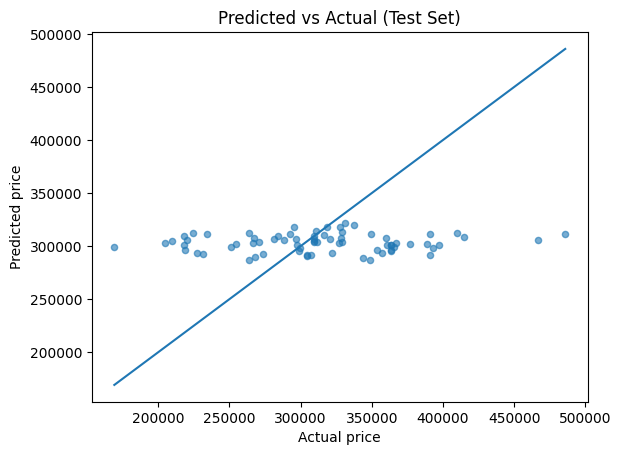

In [16]:
if track != 'housing':
    print("Skipping (current track is not 'housing').")
else:
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression

    X = df.drop('price', axis=1) 
    y = df['price']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)
    model = LinearRegression().fit(Xtr, ytr)
    y_pred = model.predict(Xte)

    lo = float(min(yte.min(), y_pred.min()))
    hi = float(max(yte.max(), y_pred.max()))

    plt.scatter(yte, y_pred, s=20, alpha=0.6)
    plt.plot([lo, hi], [lo, hi])  # 45° reference line
    plt.xlabel('Actual price')
    plt.ylabel('Predicted price')
    plt.title('Predicted vs Actual (Test Set)')
    plt.show()


### C) Partial Relationship: price vs sqft (others fixed)

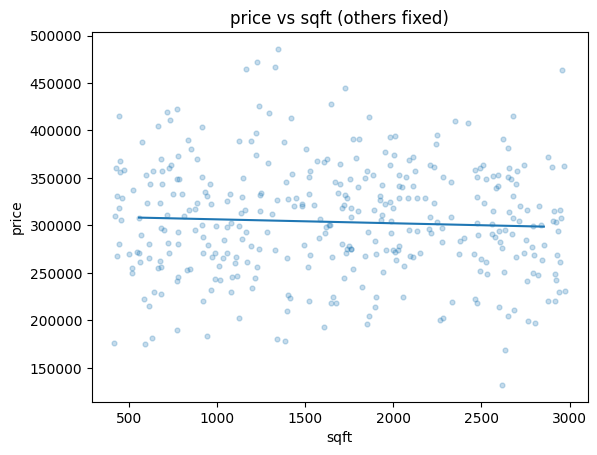

In [17]:
if track != 'housing':
    print("Skipping (current track is not 'housing').")
else:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression

    X = df.drop('price', axis=1) 
    y = df['price']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)
    model = LinearRegression().fit(Xtr, ytr)

    feat = 'sqft'
    fixed = Xtr.median(numeric_only=True).to_dict()  # fix others at medians
    x_grid = np.linspace(X[feat].quantile(0.05), X[feat].quantile(0.95), 200)

    rows = []
    for x in x_grid:
        row = fixed.copy()
        row[feat] = x
        rows.append(row)
    X_line = pd.DataFrame(rows)[Xtr.columns]
    y_line = model.predict(X_line)

    plt.scatter(df[feat], df['price'], s=12, alpha=0.25)
    plt.plot(x_grid, y_line)
    plt.xlabel('sqft') 
    plt.ylabel('price')
    plt.title('price vs sqft (others fixed)')
    plt.show()


### D) Ridge Comparison (+ Coefficients)

=== Test Metrics ===
Linear  → RMSE: 62,025 | R²: -0.022
Ridge (α=10000.0000) → RMSE: 62,014 | R²: -0.022


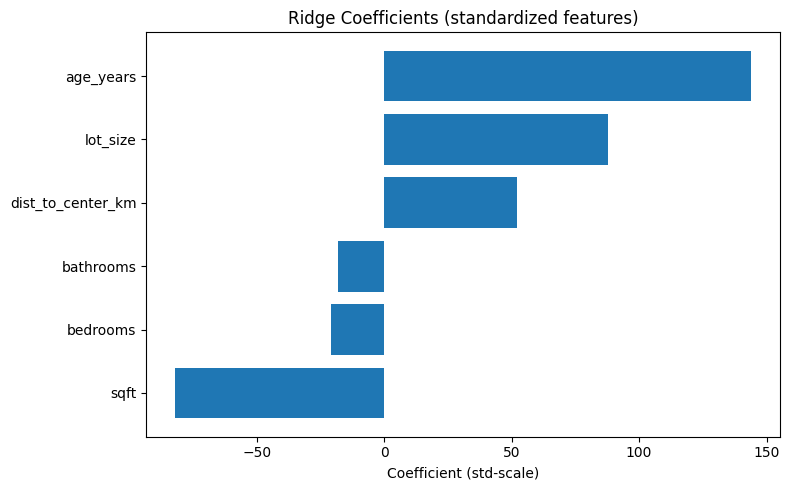

In [18]:
if track != 'housing':
    print("Skipping (current track is not 'housing').")
else:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression, RidgeCV
    from sklearn.metrics import mean_squared_error, r2_score

    X = df.drop('price', axis=1) 
    y = df['price']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Standardize -> model
    lr  = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
    rcv = make_pipeline(StandardScaler(with_mean=True), RidgeCV(alphas=np.logspace(-4, 4, 25), cv=5))

    # Fit and predict
    lr.fit(Xtr, ytr)  
    yhat_lr = lr.predict(Xte)
    rcv.fit(Xtr, ytr) 
    yhat_rg = rcv.predict(Xte)

    # Metrics
    rmse_lr = np.sqrt(mean_squared_error(yte, yhat_lr)) 
    r2_lr = r2_score(yte, yhat_lr)
    rmse_rg = np.sqrt(mean_squared_error(yte, yhat_rg))  
    r2_rg = r2_score(yte, yhat_rg)
    alpha   = rcv.named_steps['ridgecv'].alpha_

    print("=== Test Metrics ===")
    print(f"Linear  → RMSE: {rmse_lr:,.0f} | R²: {r2_lr:.3f}")
    print(f"Ridge (α={alpha:.4f}) → RMSE: {rmse_rg:,.0f} | R²: {r2_rg:.3f}")

    # Visualize Ridge coefficients on standardized scale
    coefs = rcv.named_steps['ridgecv'].coef_
    feats = X.columns
    coef_df = pd.DataFrame({'feature': feats, 'coef(std-scale)': coefs}).sort_values('coef(std-scale)')

    plt.figure(figsize=(8, 5))
    plt.barh(coef_df['feature'], coef_df['coef(std-scale)'])
    plt.title('Ridge Coefficients (standardized features)')
    plt.xlabel('Coefficient (std-scale)')
    plt.tight_layout()
    plt.show()


## Reflection prompts:
- Which change moved the metric most? Why?
- Did feature engineering help more than model choice?
- If you had 30 minutes more, what would you try next and why?